In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Change-point detection for binary time series

Imagine that it's your job to make sure a certain server is up an running as often as possible. Every day for the past year, you've recorded a "0" in your log if the server didn't crash that day, and a "1" if it did crash. Unfortunately, you're pretty sure that crashes are more frequent now than they were at the beginning of the year, probably because of some bad deployment you made at some point. 

Now, you need to look at the logs and see if crashes are actually more common now than they were before. If they are more common, find out roughly when the bad deployment probably happened. That is, given a sequence $\{C_n\}_{n=0}^{364}$ of 0s and 1s, determine whether the probabilty of getting a 1 is higher at the end than at the beginning. Then, if it is higher, estimate the point in time $n_0$ when the probability went up.

There are lots of valid approaches to this problem!

In [3]:
# data generation
p0 = 0.1
p1 = 0.5
T = 365
C = np.random.uniform(0, 1, T)
n0 = np.random.randint(100, 300)
C[:n0] = C[:n0] < p0
C[n0:] = C[n0:] < p1

In [13]:
C

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 0., 1.

In [11]:
ma = np.convolve(C, np.ones(50)/50, mode="same")

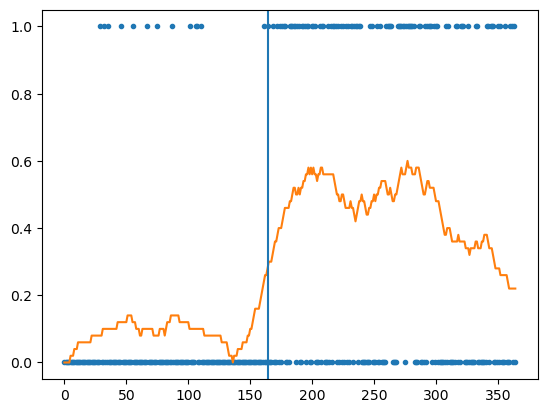

In [12]:
plt.plot(C, ".")
plt.plot(ma)
plt.axvline(n0)